<a href="https://colab.research.google.com/github/saidanaam/Potatos_disease_classification/blob/main/cnn_potatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/PlantVillage

/content/drive/MyDrive/PlantVillage


In [ ]:
data_path = '/content/drive/MyDrive/PlantVillage'

In [ ]:
tf.random.set_seed(123)

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    shuffle=True,
    batch_size= BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)

)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

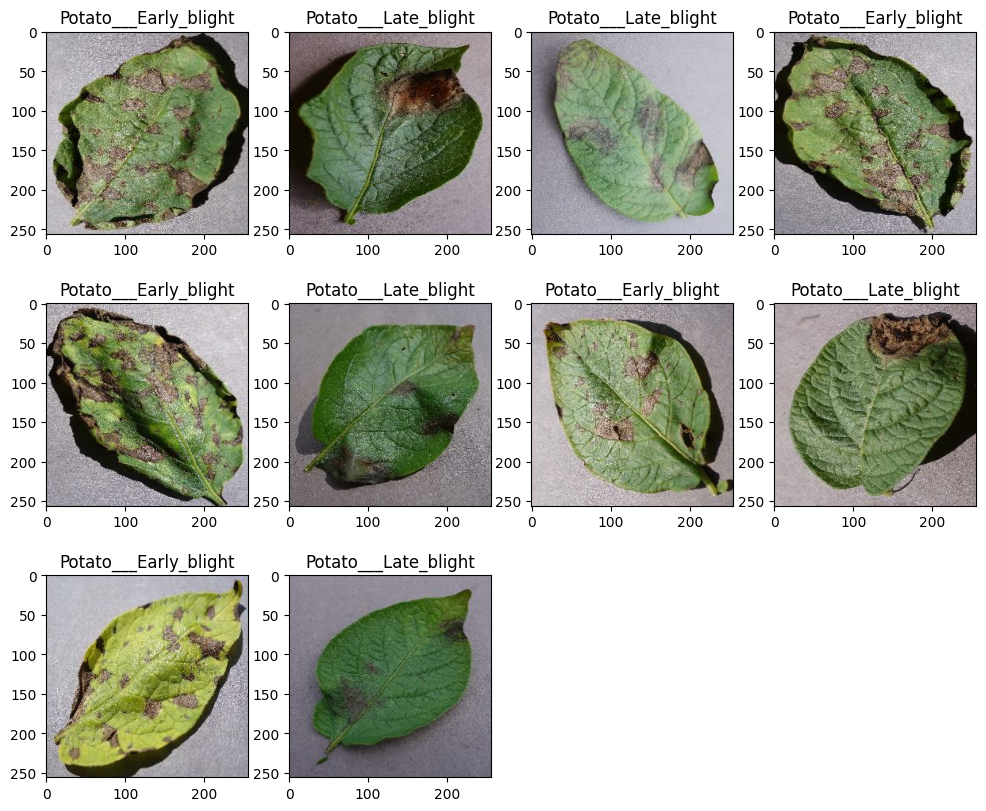

In [ ]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [ ]:
# utuiliser une fonction pour diviser notre dataset
def get_dataset_partitions_tf(data, train=0.8, validation=0.1, test=0.1, shuffle = True, shuffle_size=10000 ):
    data_size = len(data)

    if shuffle:
        data = data.shuffle(shuffle_size, seed=123)

    train_size = int(train*data_size)
    val_size = int(validation*data_size)

    train_data = data.take(train_size)
    val_data = data.take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_data)

54

In [ ]:
len(val_data)

6

In [ ]:
len(test_data)

8

In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

**image pre-preprocessing**

In [ ]:
#(pour les images différent de 256*256)
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE)
])

In [ ]:
# for rotated and flipped images ...
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
in_sh = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=in_sh),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data= val_data
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.4459 - loss: 0.9778 - val_accuracy: 0.4677 - val_loss: 0.8813
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.5076 - loss: 0.8837 - val_accuracy: 0.5217 - val_loss: 0.8298
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6431 - loss: 0.7521 - val_accuracy: 0.7342 - val_loss: 0.5994
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7046 - loss: 0.6093 - val_accuracy: 0.8169 - val_loss: 0.4355
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8057 - loss: 0.4321 - val_accuracy: 0.8609 - val_loss: 0.3657
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8677 - loss: 0.3344 - val_accuracy: 0.8773 - val_loss: 0.2981
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8687 - loss: 0.3159 - val_accuracy: 0.8515 - val_loss: 0.4215
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8616 - loss: 0.3433 - val_accuracy: 0.9114 

In [ ]:
scores = model.evaluate(test_data)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9924 - loss: 0.0267


In [ ]:
scores

[0.03168424591422081, 0.9900234937667847]

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation loss')

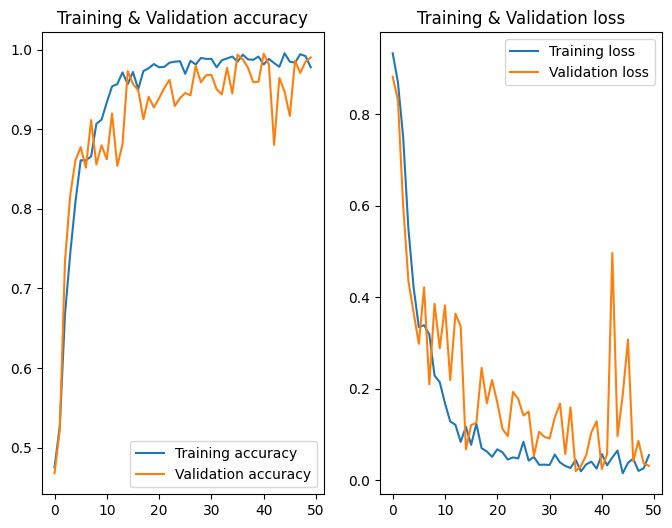

In [ ]:
plt.figure(figsize= (8,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation accuracy')
plt.legend()
plt.title('Training & Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend()
plt.title('Training & Validation loss')

actual label    : Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted label   : Potato___Late_blight


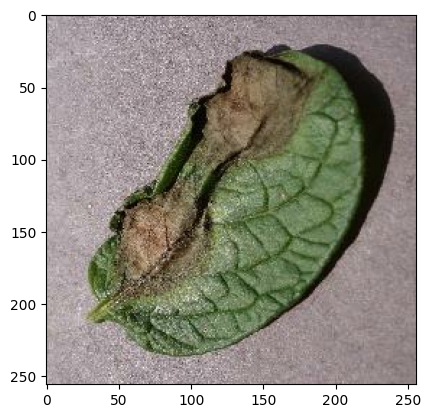

In [ ]:
for image_batch, label_batch in test_data.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  plt.imshow(first_image)
  print( "actual label    :",  class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label   :",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#import os
#model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
#model.save(f"../models/{model_version}")